<a href="https://colab.research.google.com/github/simecek/dspracticum2024/blob/main/lesson03/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# on colab
# !pip install -qq timm

In [1]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## ConvNeXt


In [3]:
model_name = "convnext_tiny.fb_in22k"
convnext = timm.create_model(model_name, pretrained=True).to(device)

# you can also list all models available or search through wildcard
# timm.list_models('*convnext*')

In [4]:
#summary(convnext, (3, 256, 256))

### download label mapping for the model

In [5]:
!wget https://dl.fbaipublicfiles.com/convnext/label_to_words.json
imagenet_labels = json.load(open('label_to_words.json'))

--2024-10-07 12:16:56--  https://dl.fbaipublicfiles.com/convnext/label_to_words.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.125.58, 3.162.125.66, 3.162.125.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.125.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773945 (756K) [application/json]
Saving to: ‘label_to_words.json’

label_to_words.json 100%[===================>] 755.81K  --.-KB/s    in 0.01s   

2024-10-07 12:16:56 (69.4 MB/s) - ‘label_to_words.json’ saved [773945/773945]



### download random image and predict it via ConvNeXt

In [6]:
!wget --output-document=test.jpeg https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
img = PIL.Image.open('test.jpeg')

# Define transforms for image
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

transformations = [
              transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC), # resize smaller edge to 256
              transforms.ToTensor(),
              transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
              ]

transformations = transforms.Compose(transformations)

img_tensor = transformations(img).unsqueeze(0).to(device)

--2024-10-07 12:17:00--  https://upload.wikimedia.org/wikipedia/commons/d/d7/Squirrel_in_Seurasaari_autumn.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338514 (1.3M) [image/jpeg]
Saving to: ‘test.jpeg’

test.jpeg           100%[===================>]   1.28M  --.-KB/s    in 0.04s   

2024-10-07 12:17:00 (30.0 MB/s) - ‘test.jpeg’ saved [1338514/1338514]



### predict label for our image

red squirrel, cat squirrel, Sciurus vulgaris 10.49%
fox squirrel, eastern fox squirrel, Sciurus niger 5.56%
American red squirrel, spruce squirrel, red squirrel, Sciurus hudsonicus, Tamiasciurus hudsonicus 4.00%
squirrel 2.53%
chickeree, Douglas squirrel, Tamiasciurus douglasi 2.33%


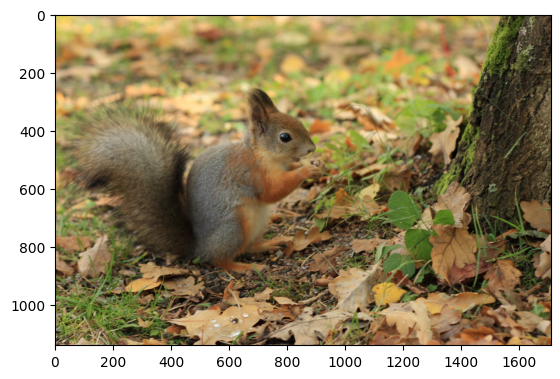

In [7]:
output = torch.softmax(convnext(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

plt.imshow(img)



---



## The Oxford-IIIT Pet Dataset

https://www.robots.ox.ac.uk/~vgg/data/pets/



In [8]:
path = untar_data(URLs.PETS)/'images'
path

Path('/teamspace/studios/this_studio/.fastai/data/oxford-iiit-pet/images')

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path, bs=64)

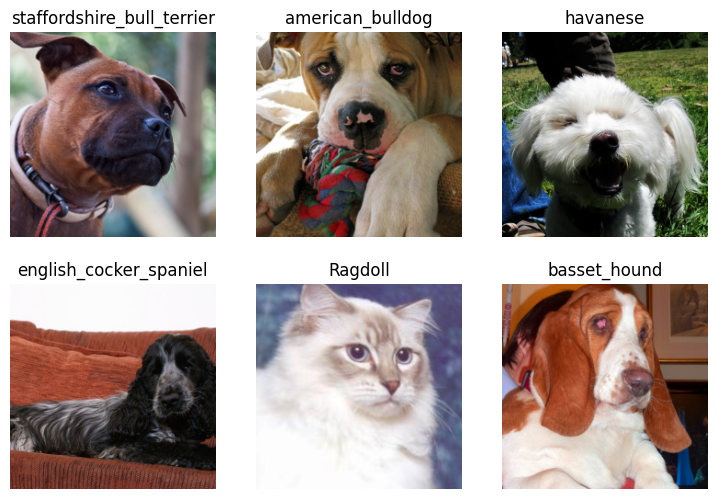

In [10]:
dls.show_batch(max_n=6)

## Load ConvNeXt model and fine-tune it

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0008317637839354575)

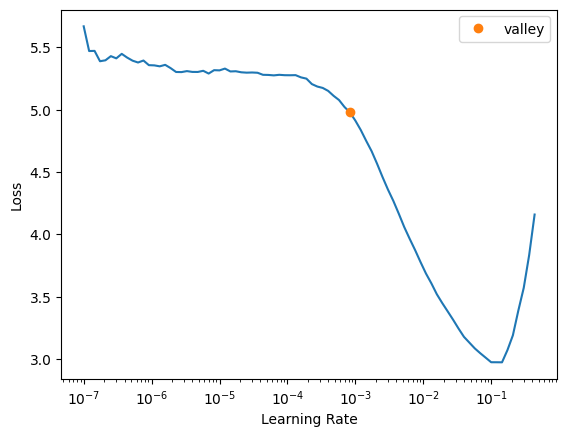

In [11]:
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.lr_find()

In [13]:
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.fine_tune(1, 0.0008317637839354575)

In [14]:
learn = vision_learner(dls, convnext_tiny, metrics=error_rate)
learn.fine_tune(3, 0.0008317637839354575, freeze_epochs=1)

## See how our model performs:


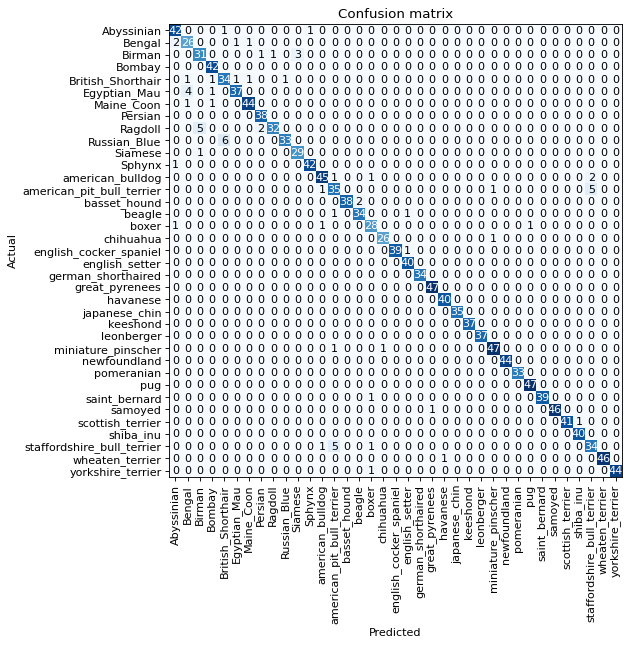

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### What is hard to predict?

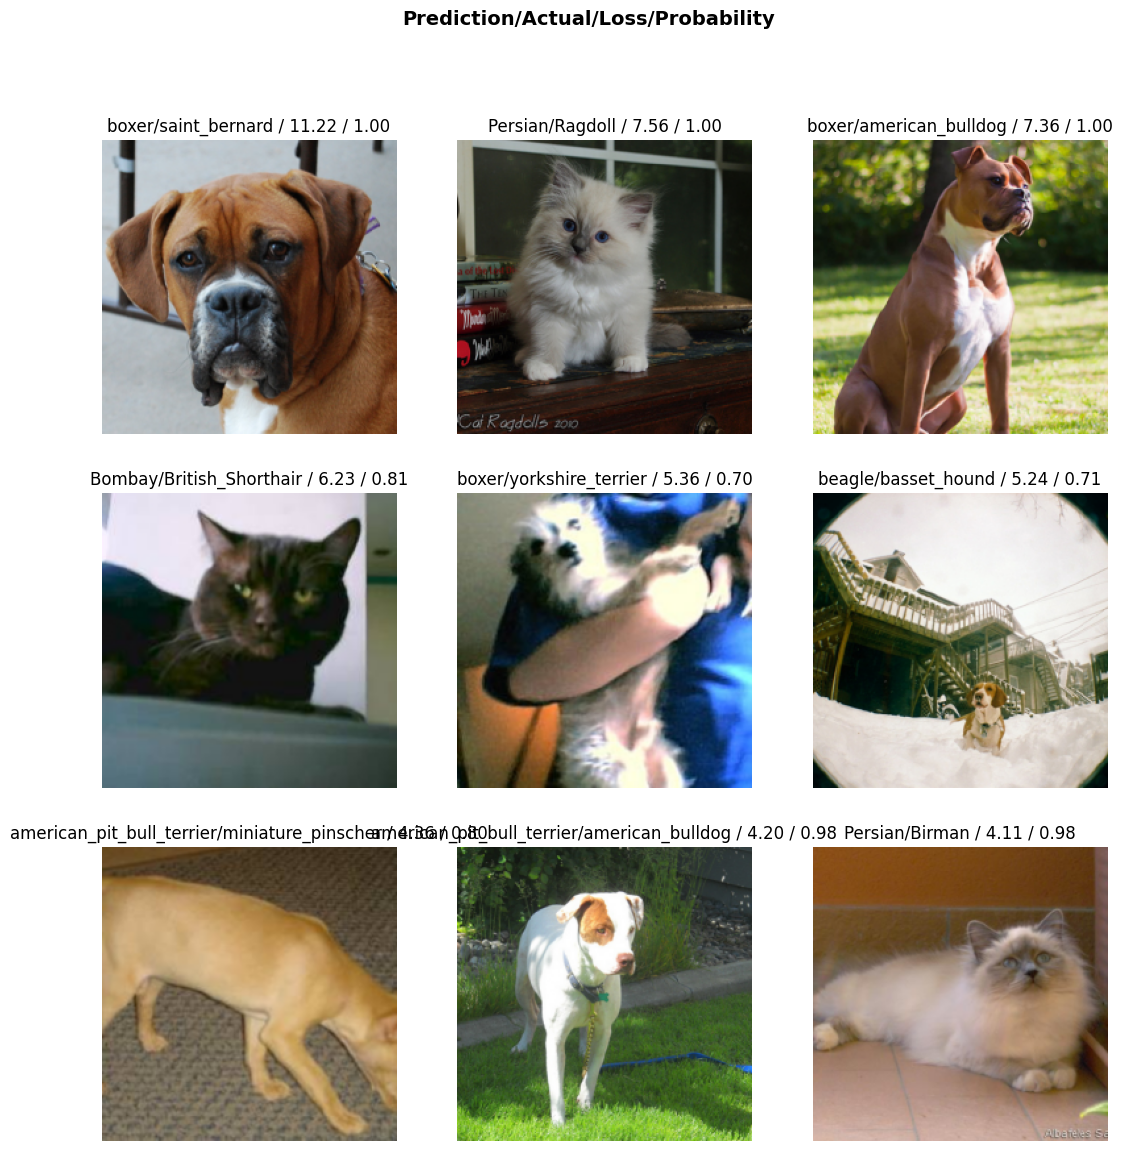

In [16]:
interp.plot_top_losses(9, figsize=(13,13))

## Predict a new image

In [ ]:
### uncoment this for colab
# from google.colab import files
# uploaded = files.upload()

In [ ]:
### uncoment this for colab
# img = PILImage.create(list(uploaded.values())[0])
# img

In [17]:
import ipywidgets as widgets
from IPython.display import display
import io

def upload_files():
    upload_widget = widgets.FileUpload(
        accept='image/*',  # Accept all image types
        multiple=False    # Only allow single file selection
    )
    display(upload_widget)
    return upload_widget

uploaded = upload_files()

FileUpload(value=(), accept='image/*', description='Upload')

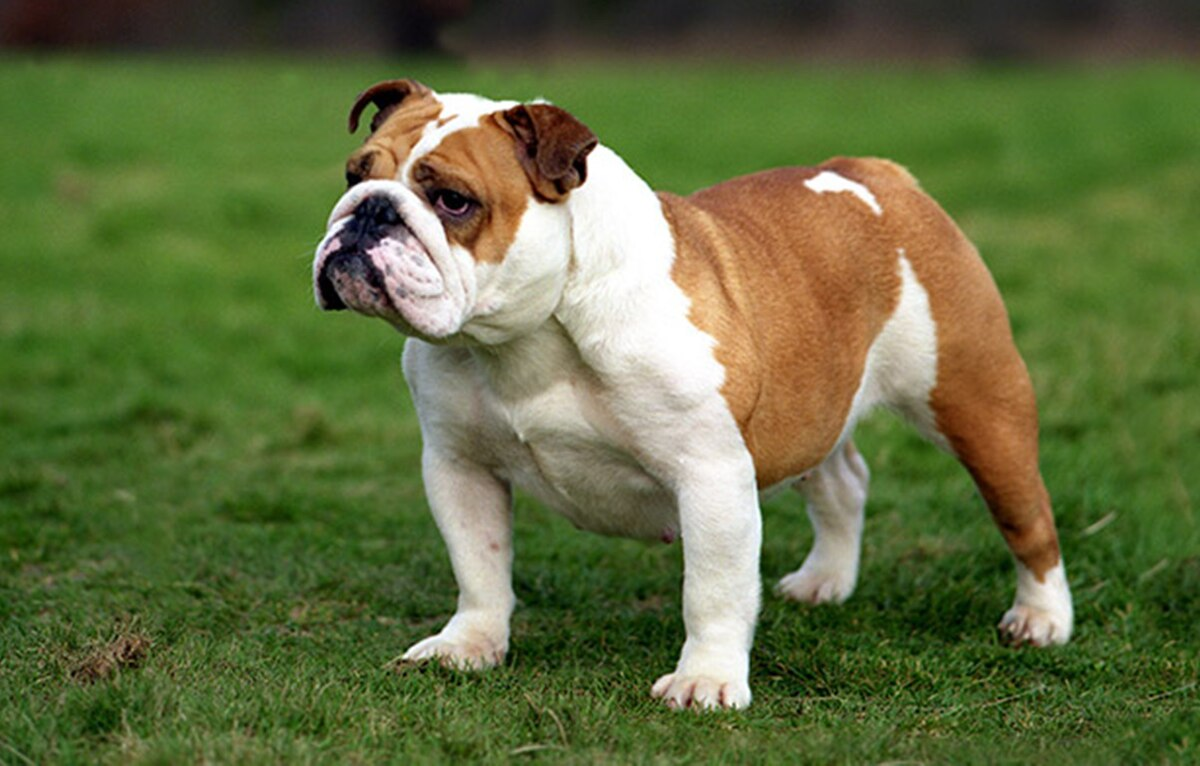

In [18]:
from PIL import Image

if len(uploaded.value) > 0:
    first_file = uploaded.value[0]
    content = first_file['content']
    img = Image.open(io.BytesIO(content))
    display(img)
else:
    print("No file has been uploaded yet.")


In [19]:
pred,pred_idx,probs = learn.predict(img)
pred,pred_idx,probs

('american_bulldog',
 tensor(12),
 tensor([2.8726e-05, 2.0500e-04, 2.3417e-05, 9.3738e-06, 4.4366e-04, 1.6003e-05,
         8.5653e-04, 4.8852e-05, 8.0586e-05, 1.8114e-05, 6.0902e-06, 9.7853e-05,
         7.7599e-01, 3.2006e-05, 5.5820e-04, 4.5864e-04, 1.9438e-01, 4.5924e-05,
         1.6705e-04, 3.6406e-05, 2.8156e-05, 1.1561e-04, 4.8401e-04, 1.4453e-04,
         1.9228e-04, 3.7548e-05, 3.9056e-05, 7.5091e-04, 5.4034e-05, 4.0117e-03,
         1.7668e-02, 3.1537e-05, 6.1381e-05, 1.8631e-04, 4.0563e-04, 6.5140e-05,
         2.2250e-03]))

## Data augmentation

use image transformations from https://docs.fast.ai/vision.augment.html

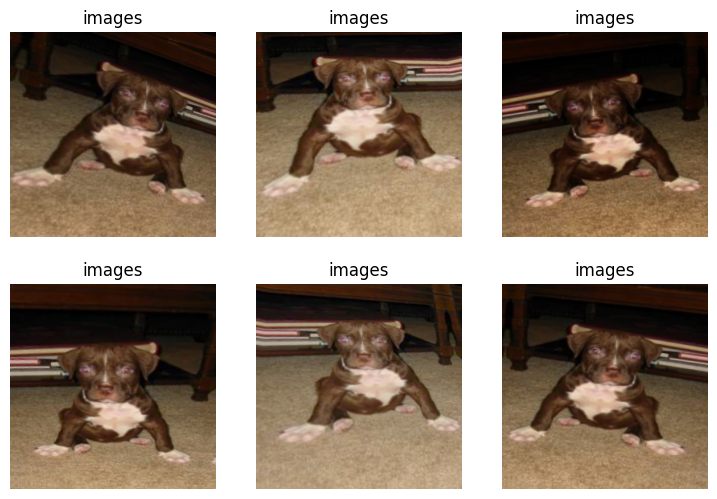

In [20]:
tfms = tfms = [
    Normalize.from_stats(*imagenet_stats),  # Normalize using ImageNet stats
    *aug_transforms(
        flip_vert=False,      # Don't flip images vertically
        max_rotate=10.0,      # Rotate by up to 10 degrees
        max_zoom=1.1,         # Zoom in up to 1.1x
        max_lighting=0.2,     # Adjust brightness
        max_warp=0.2,         # Slight warping of the image
        p_affine=0.75,        # Probability of applying affine transforms
        p_lighting=0.75,      # Probability of applying lighting transforms
    ),
]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(path, bs=64)

dls.show_batch(max_n=6, unique=True)

### Diving into `fine_tune`

Let's uncover what's inside:

`fine_tune` = `learn.freeze(), learn.fit_one_cycle(), learn.unfreeze(), learn.fit_one_cycle()`

but at first, let's have a look at what happens with the learning rate during the training we performed

In [ ]:
learn.lr_find(stop_div=False, num_it=200)

In [ ]:
learn.recorder.plot_sched(keys='lr')

In [ ]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.freeze()
learn.summary()

In [ ]:
learn.fit(1, 0.5)

In [ ]:
learn.unfreeze()
learn.fit(3, 0.5)